In [1]:
import cmath, random, numpy
import functools
import  matplotlib.pyplot as plt
import sys
import os
import math
from qutip import*

from sympy import*
#from sympsi import*
from scipy import optimize

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time
import math
from qutip import *
from qutip.ipynbtools import plot_animation
import numpy as np
import matplotlib.pyplot as plt
import qutip
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from IPython.display import display, Math, Latex
import cmath
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.special import factorial as fac


In [8]:
"""Define the operators for MZI - we will deal in Heisenberg """
T = Symbol('T')
xvec = np.arange(-40.,40.)*5./40
yvec = np.arange(-50.,50)*5/40
X,Y = np.meshgrid(xvec, xvec)  ##Some plotting params
X1,Y1 = np.meshgrid(yvec,yvec)
N_dim = 25##Dimenstion of the Hilbert space - this must be large enough depending on calculation being done

a1 = destroy(N_dim) ##This is for single-photon field
a2 = destroy(N_dim) ##for coherent field
a3 = destroy(N_dim) ##for vacuum field
def n_choose_k(n,k):
    return fac(n)/(fac(n-k)*fac(k))
def D(state,alpha):
    Rho_new=displace(N_dim,alpha)*state*displace(N_dim,alpha).dag()
    return Rho_new   
'''Define a rotation in phase space, or phase shifter operation'''
def Phase(theta):
    b=-1j*theta*a1.dag()*a1;
    return b.expm()
'''Squeezing operation, inputs a density matrix and outputs the squeezed density matrix for squeezing parameter r'''
def Sq(state,r):
    Rho_new=squeeze(N_dim,r)*state*squeeze(N_dim,r).dag();
    return Rho_new
'''The function below creates a beamsplitter operation that acts on two modes.  
The value for k determines what number Fock state could be filtered out of the first state
based on a single photon input for the second BS port, followed by single photon detection.'''
def BS_operator_filtering(a1, a2, k):
    theta_k = np.arctan(1/np.sqrt(k))
    T = np.sin(theta_k)*np.sin(theta_k)
    R = np.cos(theta_k)*np.cos(theta_k)
    print('I am filtering', k, 'and:', theta_k*180/math.pi)
    print('BS T is : ', T, 'and : ', R)
    b = theta_k*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))
    return b.expm()
def sq_tri_cat(r,amp):
    state=ket2dm((displace(N_dim,amp)*squeeze(N_dim,r)*fock(N_dim,0)+displace(N_dim,amp*np.e**(2j*np.pi/3))*squeeze(N_dim,r*np.e**(4j*np.pi/3))*fock(N_dim,0)+displace(N_dim,amp*np.e**(4j*np.pi/3))*squeeze(N_dim,r*np.e**(2j*np.pi/3))*fock(N_dim,0)))
    norm_state=state/state.tr()
    return norm_state
def SSV_plus(r,alpha):
    state = ket2dm((displace(N_dim,alpha)+displace(N_dim,-alpha))*squeeze(N_dim,r)*fock(N_dim,0))
    norm_state = state/state.tr()
    return norm_state
def SSV_minus(r,alpha):
    state = ket2dm((displace(N_dim,alpha)-displace(N_dim,-alpha))*squeeze(N_dim,r)*fock(N_dim,0))
    norm_state = state/state.tr()
    return norm_state
def cat_plus(alpha):
    cat = (1/(np.sqrt(2)*np.sqrt(1+np.e**(-alpha*alpha.conj()))))*(coherent(N_dim,-alpha)+(coherent(N_dim,alpha)))
    return cat
def cat_minus(alpha):
    cat = (1/(np.sqrt(2)*np.sqrt(1-np.e**(-alpha*alpha.conj()))))*(-coherent(N_dim,-alpha)+(coherent(N_dim,alpha)))
    return cat
def pnr_resolution_detector(eta, click, n_truc):
    pi_n = 0;
    l = np.arange(click,n_truc)
    for i in l:
        pi_n +=  n_choose_k(i,click)*math.pow((1-eta),(i-click))*math.pow(eta,click)*fock(N_dim,i)*fock(N_dim,i).dag()
        #print("The final Povm element is: ", pi_0)
    return Qobj(pi_n)
def Fock_Filter_povm(in_state,in_fock,refl,num_det,eta,n_truc):
    Projector = tensor(pnr_resolution_detector(eta, num_det, n_truc),qeye(N_dim));
    Initial_state=tensor(in_state,ket2dm(fock(N_dim,in_fock)));
    theta_k=np.arccos(np.sqrt(refl));
    
    BS1= ((theta_k)*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))).expm()
        
    Rho=BS1*Initial_state*BS1.dag();
        
    Rho_filtered = ((Rho*Projector).ptrace(1))/((Rho*Projector).tr())
    '''The operation .ptrace(m) takes the partial trace over every mode EXCEPT m, where the numbering 
    startes at 0.  So .ptrace(1) means you keep mode 1, which is actually the 2nd mode'''
    print('BS has reflectivity',refl,' and I am detecting the |',num,'> state, where my detector has efficiency', eta)
    return Rho_filtered
def Fock_Filter_prob(in_state,in_fock,refl,num_det,eta,n_truc):
    Projector = tensor(pnr_resolution_detector(eta, num_det, n_truc),qeye(N_dim));
    Initial_state=tensor(in_state,ket2dm(fock(N_dim,in_fock)));
    theta_k=np.arccos(np.sqrt(refl));
    
    BS1= ((theta_k)*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))).expm()
        
    Rho=BS1*Initial_state*BS1.dag();
    P=(Rho*Projector).tr()
    print('The probability of a sucessful detection is:',P)    
    Rho_filtered = ((Rho*Projector).ptrace(1))/((Rho*Projector).tr())
    #Rho_filtered=Rho*Projector
    '''The operation .ptrace(m) takes the partial trace over every mode EXCEPT m, where the numbering 
    startes at 0.  So .ptrace(1) means you keep mode 1, which is actually the 2nd mode'''
    print('BS has reflectivity',refl,' and I am detecting the |',num,'> state, where my detector has efficiency', eta)
    return Rho_filtered
def catalysis(in1,in2,refl,num_det,eta,n_truc):
    Projector = tensor(pnr_resolution_detector(eta, num_det, n_truc),qeye(N_dim));
    Initial_state=tensor(in1,in2);
    theta_k=np.arccos(np.sqrt(refl));
    
    BS1= ((theta_k)*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))).expm()
        
    Rho=BS1*Initial_state*BS1.dag();
    
    P=(Rho*Projector).tr()
    print('The probability of a sucessful detection is:',P)   
    
    Rho_filtered = ((Rho*Projector).ptrace(1))/((Rho*Projector).tr())
    '''The operation .ptrace(m) takes the partial trace over every mode EXCEPT m, where the numbering 
    startes at 0.  So .ptrace(1) means you keep mode 1, which is actually the 2nd mode'''
    print('BS has reflectivity',refl,' and I am detecting the |',num,'> state, where my detector has efficiency', eta)
    return Rho_filtered

def fid(state1,state2):
    F=np.absolute((state1.sqrtm()*state2*state1.sqrtm()).sqrtm().tr())
    return F


In [3]:
###Re-derived the hex_GKP and made sure.  Made a couple of small modifications, but my code now works too!
def my_hex_GKP(mu, d, delta, cutoff, nmax=400):
    r"""Hexagonal GKP code state.
    The Hex GKP state is defined by
    .. math::
        |mu> = \sum_{n_1,n_2=-\infty}^\infty e^{-i(q+\sqrt{3}p)/2}
            \sqrt{4\pi/\sqrt{3}d}(dn_1+\mu) e^{iq\sqrt{4\pi/\sqrt{3}d}n_2}|0>
    where d is the dimension of a code space, \mu=0,1,...,d-1, |0> is the
    vacuum state, and the states are modulated by a Gaussian envelope in the
    case of finite energy:
    ..math:: e^{-\Delta ^2 n}|\mu>
    Args:
        d (int): the dimension of the code space.
        mu (int): mu=0,1,...,d-1.
        delta (float): width of the modulating Gaussian envelope.
        cutoff (int): the Fock basis truncation of the returned state vector.
        nmax (int): the Hex GKP state |mu> is calculated by performing the
            sum using n1,n1=-nmax,...,nmax.
    Returns:
        array: a size [cutoff] complex array state vector.
    """
    n1 = np.arange(-nmax, nmax+1)[:, None]
    n2 = np.arange(-nmax, nmax+1)[None, :]

    n1sq = n1**2
    n2sq = n2**2

    sqrt3 = np.sqrt(3)

    #arg1 = -1j*np.pi*n2*(d*n1+mu)/d
    arg1 = -1j*np.pi*n2*(d*n1+mu)/d
    arg2 = -np.pi*(d**2*n1sq+n2sq-d*n1*(n2-2*mu)-n2*mu+mu**2)/(sqrt3*d)
    arg2 *= 1-np.exp(-2*delta**2)

    #amplitude = (np.exp(arg1)*np.exp(arg2)).flatten()[:, None]
    amplitude = (np.exp(arg1)).flatten()[:, None]


    alpha = np.sqrt(np.pi/(2*sqrt3*d)) * (sqrt3*(d*n1+mu) - 1j*(d*n1-2*n2+mu))
    #alpha *= np.exp(-delta**2)

    alpha = alpha.flatten()[:, None]
    n = np.arange(cutoff)[None, :]
    coherent = np.exp(-0.5*np.abs(alpha)**2)*alpha**n/np.sqrt(fac(n))
    
    #hex_state = np.sum(amplitude*coherent*np.exp(-n*delta**2), axis=0)
    hex_state = ket2dm(Qobj(np.sum(amplitude*coherent*np.exp(-n*delta**2), axis=0)))
    final=hex_state/hex_state.tr()
    return final

In [4]:
###NEWLY OPTIMIZED PARAMETERS FOR THE TRI-SSV STATE###
###Obtained by optimizing Eq. (22) from the paper###

refl1= .576813**2; refl2=0.54398**2; refl3=0.55;refl4=0.42134**2;
delta=4.8772; beta=2.26; sq=0.476595; alpha=1.59; n1=6;n2=4;n3=2;n4=1
eta=1;

#Perform the first photon catlysis step
first=Fock_Filter_prob(ket2dm(coherent(N_dim,delta)),1,refl1,n1,eta,N_dim)
W1=wigner(first,yvec,yvec);
#Perform the second photon catlysis step
second=Fock_Filter_prob(first,1,refl2,n2,eta,N_dim);
W2=wigner(second,yvec,yvec);
#Perform the third photon catlysis step
third=Fock_Filter_prob(second,1,refl3,n3,eta,N_dim);
W3=wigner(third,yvec,yvec);
#Displace back to the origin of phase-space to compare with the target
catalyzed=D(third,-beta);
W_fin=wigner(catalyzed,xvec,xvec);

The probability of a sucessful detection is: 0.08125622285789687
BS has reflectivity 0.332713236969  and I am detecting the | <function num at 0x000002AB6A750048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.11588192440241311
BS has reflectivity 0.29591424040000003  and I am detecting the | <function num at 0x000002AB6A750048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.008415971050254392
BS has reflectivity 0.55  and I am detecting the | <function num at 0x000002AB6A750048> > state, where my detector has efficiency 1


In [ ]:
#Define an ideal M=3 SSV state that is closest to the protocol
amp=1.255
sq=.24
new=sq_tri_cat(sq,amp)
W_new=wigner(new,xvec,xvec);

#Plot the Wigner function of ideal state
fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_new, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_new, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of tri-displaced, squeezed, vac state')

#Plot the Wigner function of photon-catalyzed state
fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_fin, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_fin, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of catalyzed state (shifted)')

fid=fidelity(catalyzed,new)
print('fidelity between these states',fid**2)

plt.show()

#Plot the photon-number distributions

fig, axes = plt.subplots(1, 3, figsize=(12,4))
bar0 = axes[0].bar(range(N_dim), catalyzed.diag())

lbl0 = axes[0].set_title("catalyzed State")

lim0 = axes[0].set_xlim([-.5, 8])
bar1 = axes[1].bar(range(N_dim), new.diag())

lbl1 = axes[1].set_title("target state")

lim1 = axes[1].set_xlim([-.5, 8])

bar2 = axes[2].bar(range(N_dim), ket2dm(coherent(N_dim,delta)).diag())

lbl2 = axes[2].set_title("Initial Coherent State")

lim2 = axes[2].set_xlim([-.5, 35])
plt.show()

Text(0.5,0.92,'mixture gkp 0 + 1')

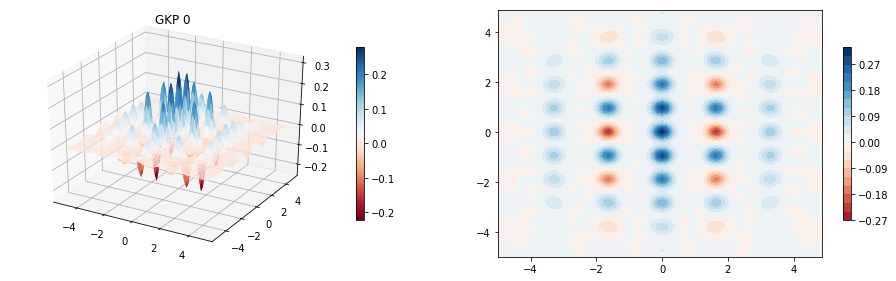

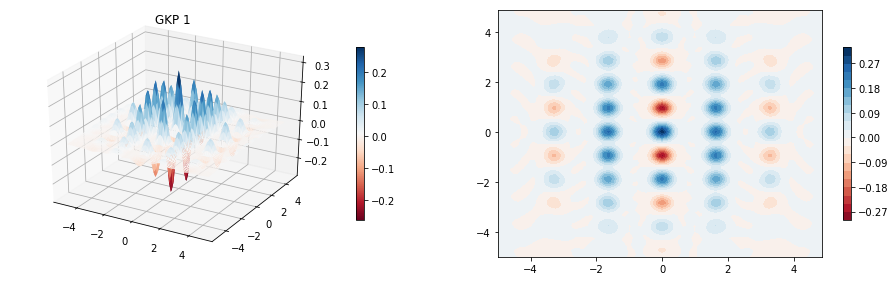

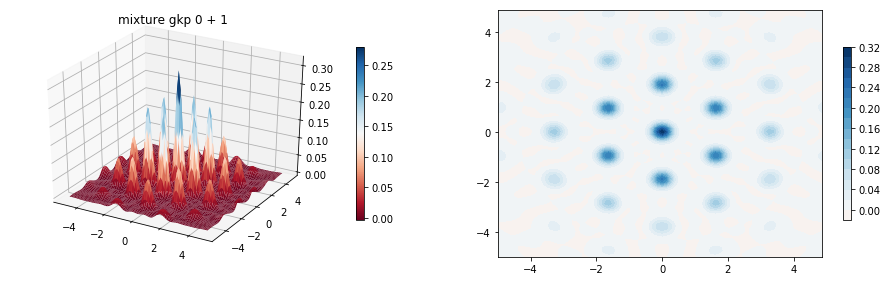

In [27]:
code_d=2 #code-space dimension for GKP

#Different GKP states
hex_gkp0=my_hex_GKP(0,code_d,0.3,35)
hex_gkp1=my_hex_GKP(1,code_d,0.3,35)
hex_gkp_mix=(hex_gkp0+hex_gkp1)/(hex_gkp0+hex_gkp1).tr()

#associated Wigner functions
W_hex_mix=wigner(hex_gkp_mix,xvec,xvec)
W_hex0=wigner(hex_gkp0,xvec,xvec)
W_hex1=wigner(hex_gkp1,xvec,xvec)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_hex0, 20, cmap=cm.RdBu, vmin=-1/np.pi, vmax=1/np.pi)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_hex0, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('GKP 0')

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_hex1, 20, cmap=cm.RdBu, vmin=-1/np.pi, vmax=1/np.pi)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_hex1, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('GKP 1')

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_hex_mix, 20, cmap=cm.RdBu, vmin=-1/np.pi, vmax=1/np.pi)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_hex_mix, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('mixture gkp 0 + 1')

In [9]:
'''Take two equivalent ideal M=3 symmetry SSV states obtained from the optimized photon-catalysis
proceedure, send them to a balance beamsplitter.  Then, perform a homodyne detection on one output.
How does the detection result project the state?'''
amp=1.255
sq=.24
state=sq_tri_cat(sq,amp);
in1=state.full()
in2=state.full()
import strawberryfields as sf
from strawberryfields.ops import *
import tensorflow as tf
eng, q = sf.Engine(2)
with eng:
    Ket(in1) | q[0]
    Ket(in2) | q[1]
    BSgate()  | (q[0], q[1])
    MeasureHomodyne(np.pi/2,select=0) | q[0]
    #wigner | (q[1].val)
state_final1 = eng.run('tf', cutoff_dim =25, modes=1, eval=True)
qutip_state1=Qobj(state_final1.dm())
W_homodyne1=wigner(qutip_state1,xvec,xvec)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


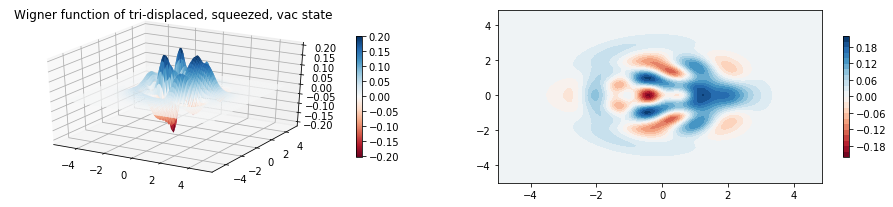

'No hexagonal symmetry!  The homodyne detection projects along a generalized quadrature,\nso the resultant state does not'

In [10]:
'''Now plot the result of the homodyne detection.'''
fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_homodyne1, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_homodyne1, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of tri-displaced, squeezed, vac state')
plt.show()

'''No hexagonal symmetry!  The homodyne detection projects along a generalized quadrature,
so the resultant state only has 180 degree rotational symmetry.'''

In [32]:
###NOTE - need to rerun the first cell before proceeding, there is some package incompatability

'''Now, lets try with PNR detection. Take the ideal M=3 symmetry SSV state obtained from the 
optimized photon-catalysis proceedure and perform general photon catalysis again (instead of 
single-photon input) with two of them.  In other words, send two M=3 symmetric SSV state to 
a balanced beamsplitter and then send one output to a PNR detector and detect n photons.  
The remaining mode is projected into the state output_n.'''


amp=1.255
sq=.24

state=sq_tri_cat(sq,amp);
W_start=wigner(state,xvec,xvec);

output0=catalysis(state,state,1/2,0,eta,N_dim)
#output1=catalysis(state,state,1/2,1,eta,N_dim)
output2=catalysis(state,state,1/2,2,eta,N_dim)
#output3=catalysis(state,state,1/2,3,eta,N_dim)
output4=catalysis(state,state,1/2,4,eta,N_dim)
#output5=catalysis(state,state,1/2,5,eta,N_dim)
output6=catalysis(state,state,1/2,6,eta,N_dim)
#output7=catalysis(state,state,1/2,7,eta,N_dim)
output8=catalysis(state,state,1/2,8,eta,N_dim)

W_out0=wigner(output0,xvec,xvec)
#W_out1=wigner(output1,xvec,xvec)
W_out2=wigner(output2,xvec,xvec)
#W_out3=wigner(output3,xvec,xvec)
W_out4=wigner(output4,xvec,xvec)
#W_out5=wigner(output5,xvec,xvec)
W_out6=wigner(output6,xvec,xvec)
#W_out7=wigner(output7,xvec,xvec)
W_out8=wigner(output8,xvec,xvec)


The probability of a sucessful detection is: 0.42744855753819244
BS has reflectivity 0.5  and I am detecting the | <function num at 0x00000136D7060048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.4323513240583268
BS has reflectivity 0.5  and I am detecting the | <function num at 0x00000136D7060048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.04842803490589212
BS has reflectivity 0.5  and I am detecting the | <function num at 0x00000136D7060048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.09165466647398235
BS has reflectivity 0.5  and I am detecting the | <function num at 0x00000136D7060048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.00011735555166136714
BS has reflectivity 0.5  and I am detecting the | <function num at 0x00000136D7060048> > state, where my detector has efficiency 1


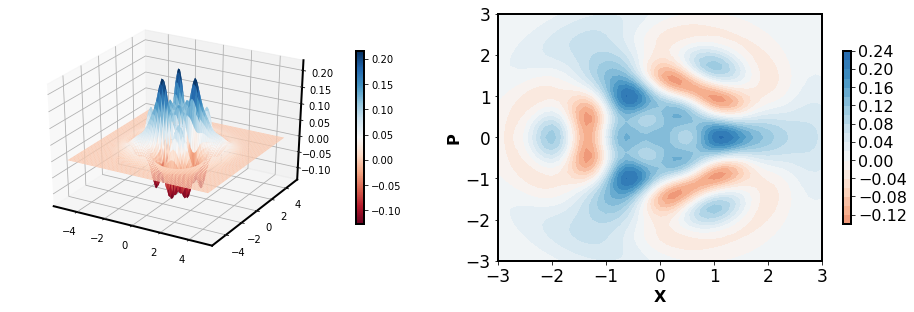

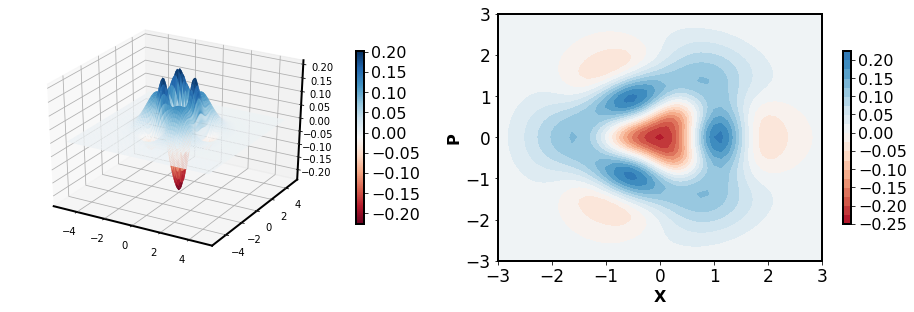

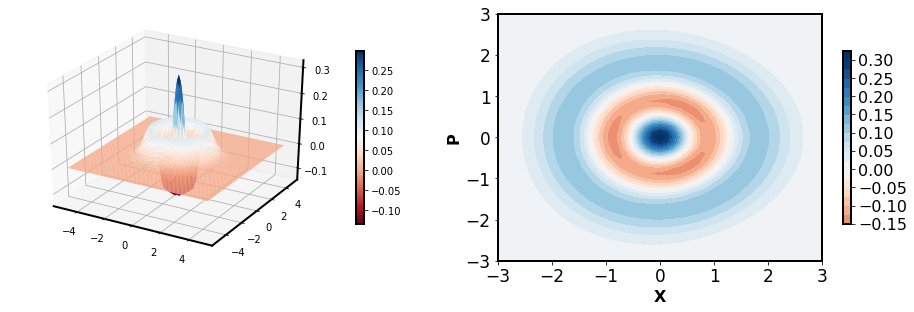

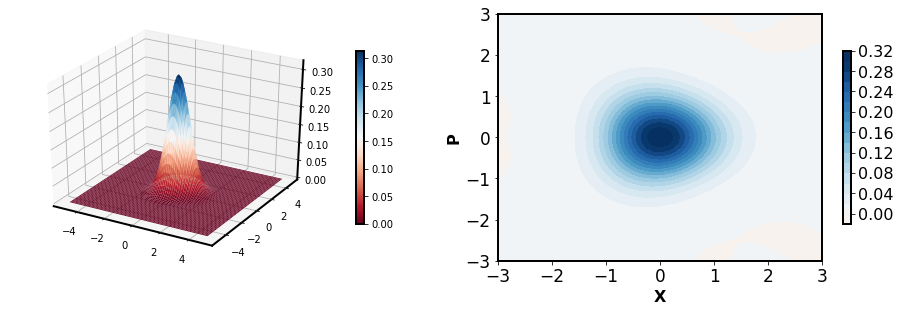

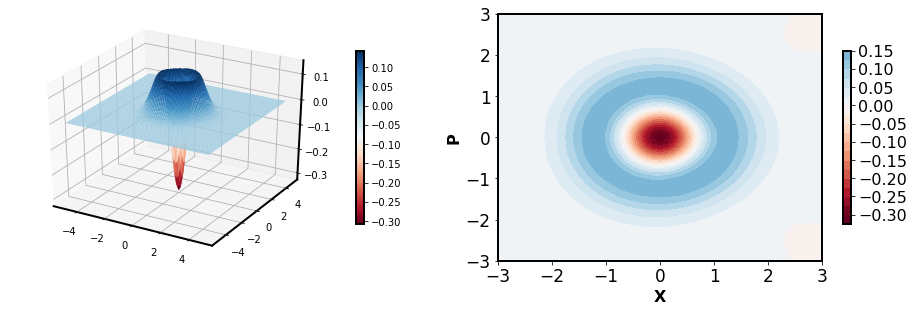

In [34]:
#some plotting parameters to make everything look nicer
from pylab import *
rc('axes', linewidth=2)
fontsize=14
fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_out0, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
cb.ax.tick_params(labelsize=16)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_out0, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)


#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_out2, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
cb.ax.tick_params(labelsize=16)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_out2, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
cb.ax.tick_params(labelsize=16)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_out4, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
cb.ax.tick_params(labelsize=16)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_out4, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_out6, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
cb.ax.tick_params(labelsize=16)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_out6, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_out8, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
cb.ax.tick_params(labelsize=16)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_out8, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)



C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\transforms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


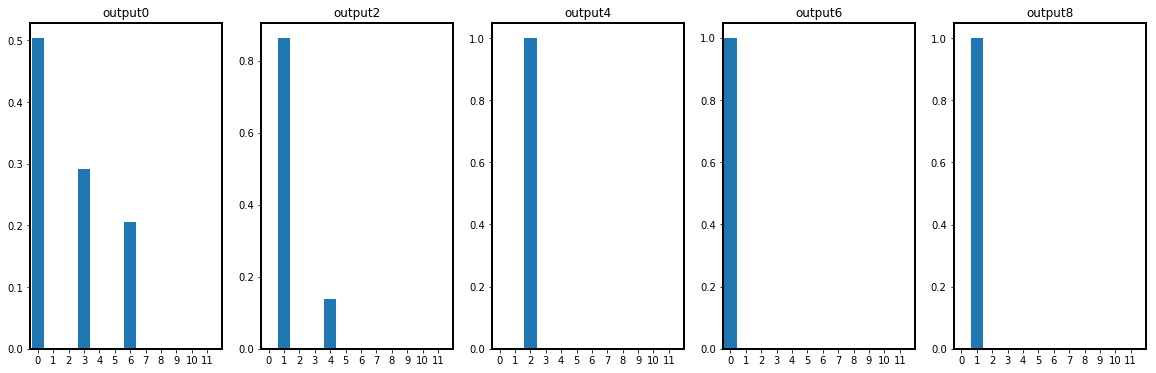

In [35]:
fig, axes = plt.subplots(1, 5, figsize=(20,6))
bar0 = axes[0].bar(range(N_dim), output0.diag())
lbl0 = axes[0].set_title("output0")
lim0 = axes[0].set_xlim([-.5, 12])

bar1 = axes[1].bar(range(N_dim), output2.diag())
lbl1 = axes[1].set_title("output2")
lim1 = axes[1].set_xlim([-.5, 12])

bar2 = axes[2].bar(range(N_dim), output4.diag())
lbl2 = axes[2].set_title("output4")
lim2 = axes[2].set_xlim([-.5, 12])
bar3 = axes[3].bar(range(N_dim), output6.diag())
lbl3 = axes[3].set_title("output6")
lim3 = axes[3].set_xlim([-.5, 12])

bar4 = axes[4].bar(range(N_dim), output8.diag())
lbl4 = axes[4].set_title("output8")
lim4 = axes[4].set_xlim([-.5, 12])


axes[0].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[1].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[2].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[3].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[4].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])

plt.show()

In [39]:
'''Do the same thing as before, but now apply a phase shift to one of the modes before 
it enters the beamsplitter.  How does this change the output?'''
amp=1.255
sq=.24

state=sq_tri_cat(sq,amp);
W_start=wigner(state,xvec,xvec);

tri0=catalysis(state,Phase(np.pi/6)*state*Phase(np.pi/6).dag(),1/2,0,eta,N_dim)
tri1=catalysis(state,Phase(np.pi/6)*state*Phase(np.pi/6).dag(),1/2,1,eta,N_dim)
tri2=catalysis(state,Phase(np.pi/6)*state*Phase(np.pi/6).dag(),1/2,2,eta,N_dim)
tri3=catalysis(state,Phase(np.pi/6)*state*Phase(np.pi/6).dag(),1/2,3,eta,N_dim)
tri4=catalysis(state,Phase(np.pi/6)*state*Phase(np.pi/6).dag(),1/2,4,eta,N_dim)
tri5=catalysis(state,Phase(np.pi/6)*state*Phase(np.pi/6).dag(),1/2,5,eta,N_dim)
tri6=catalysis(state,Phase(np.pi/6)*state*Phase(np.pi/6).dag(),1/2,6,eta,N_dim)
tri7=catalysis(state,Phase(np.pi/6)*state*Phase(np.pi/6).dag(),1/2,7,eta,N_dim)
tri8=catalysis(state,Phase(np.pi/6)*state*Phase(np.pi/6).dag(),1/2,8,eta,N_dim)

W_0=wigner(tri0,xvec,xvec)
W_1=wigner(tri1,xvec,xvec)
W_2=wigner(tri2,xvec,xvec)
W_3=wigner(tri3,xvec,xvec)
W_4=wigner(tri4,xvec,xvec)
W_5=wigner(tri5,xvec,xvec)
W_6=wigner(tri6,xvec,xvec)
W_7=wigner(tri7,xvec,xvec)
W_8=wigner(tri8,xvec,xvec)


The probability of a sucessful detection is: 0.3671024001124088
BS has reflectivity 0.5  and I am detecting the | <function num at 0x00000136D7060048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.18652304928584368
BS has reflectivity 0.5  and I am detecting the | <function num at 0x00000136D7060048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.24022807445029284
BS has reflectivity 0.5  and I am detecting the | <function num at 0x00000136D7060048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.06237350306705309
BS has reflectivity 0.5  and I am detecting the | <function num at 0x00000136D7060048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.053836534111612926
BS has reflectivity 0.5  and I am detecting the | <function num at 0x00000136D7060048> > state, where my detector has efficiency 1
The probability of a

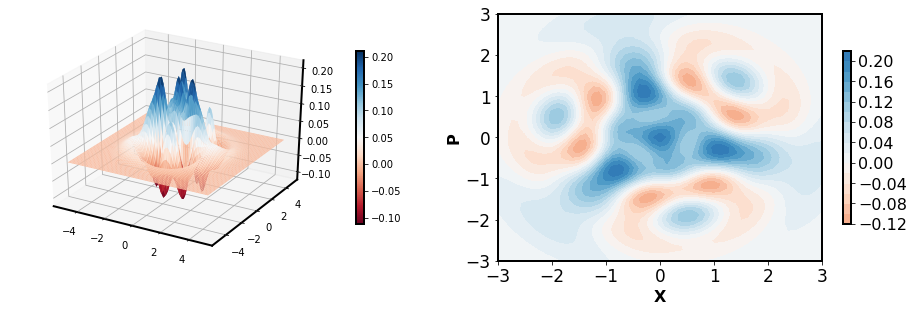

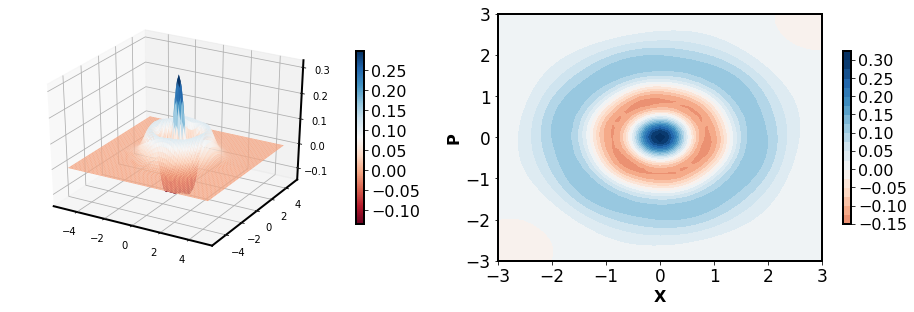

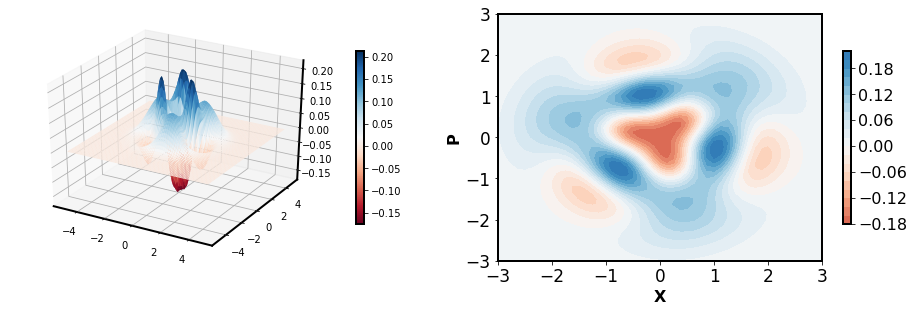

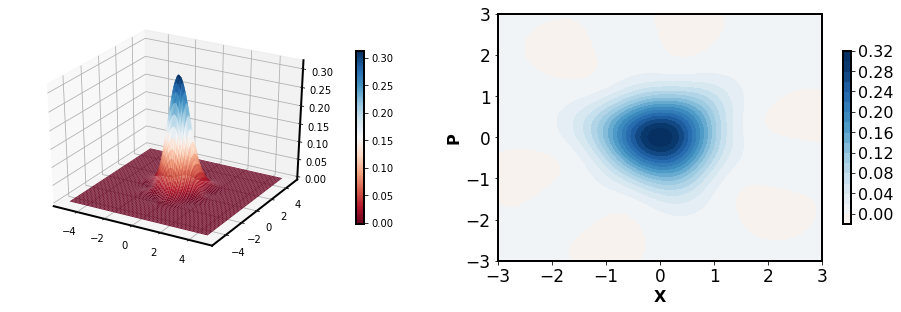

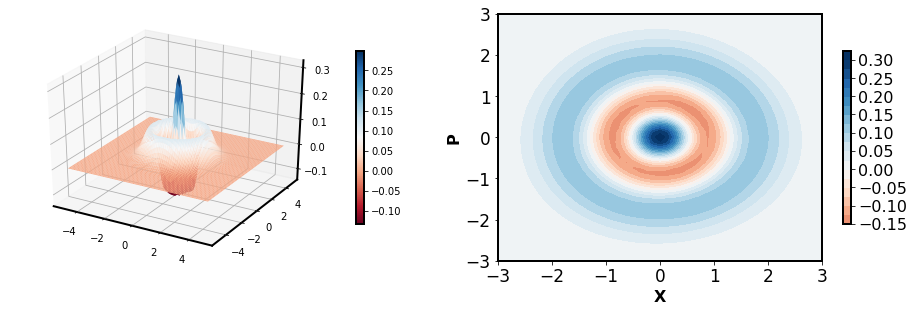

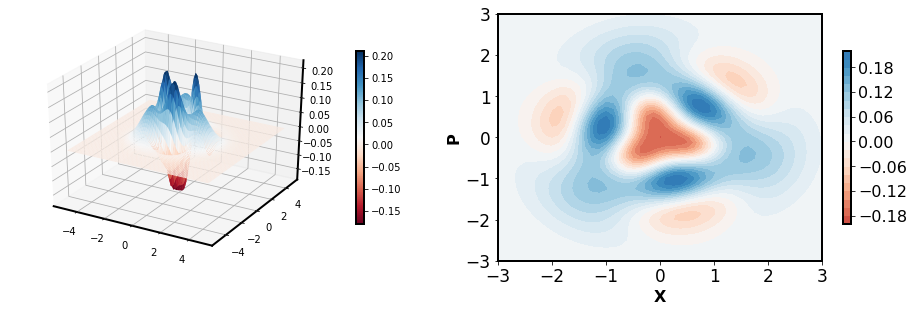

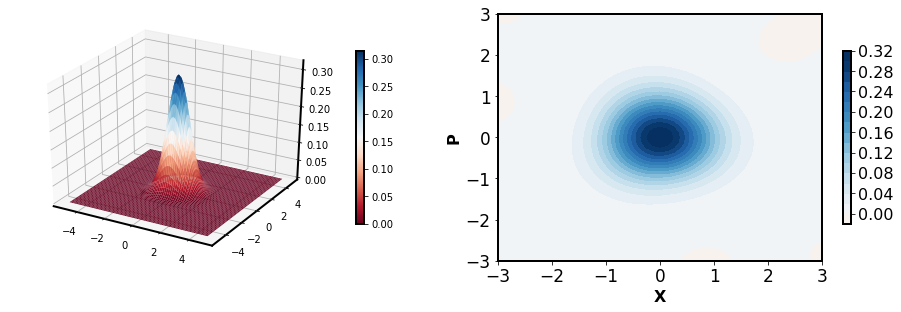

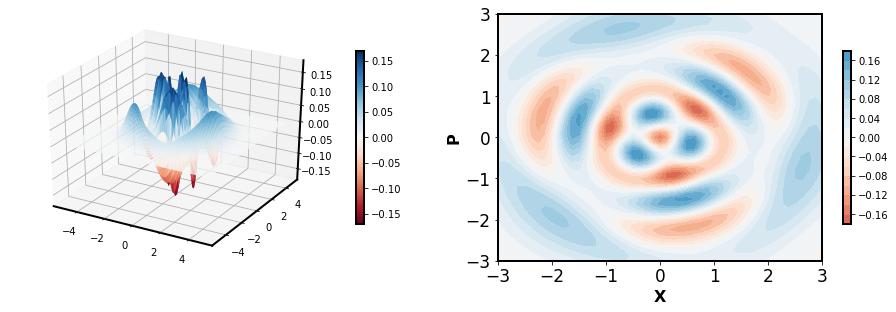

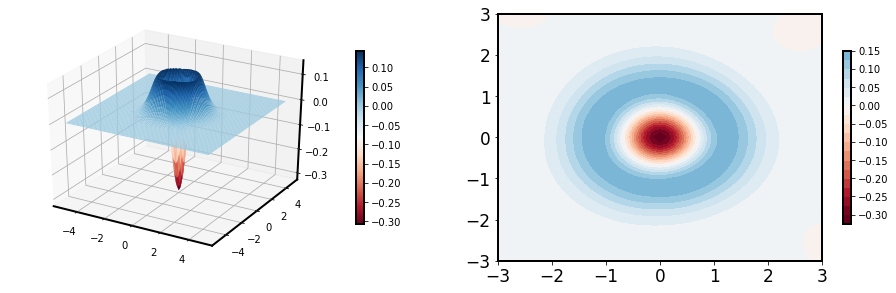

In [41]:
#plotting again
from pylab import *
rc('axes', linewidth=2)
fontsize=14
fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_0, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
cb.ax.tick_params(labelsize=16)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_0, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)


#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_1, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
cb.ax.tick_params(labelsize=16)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_1, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
cb.ax.tick_params(labelsize=16)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_2, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
cb.ax.tick_params(labelsize=16)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_2, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_3, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
cb.ax.tick_params(labelsize=16)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_3, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_4, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
cb.ax.tick_params(labelsize=16)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_4, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_5, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
cb.ax.tick_params(labelsize=16)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_5, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_6, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
cb.ax.tick_params(labelsize=16)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_6, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_7, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_7, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_8, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_8, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)



C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\transforms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


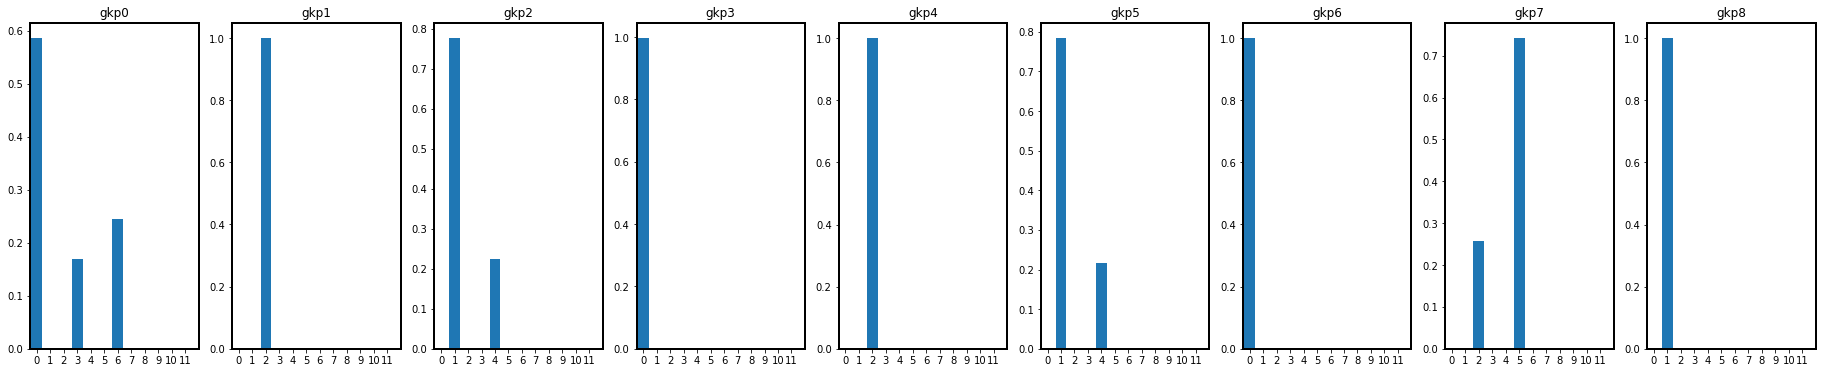

In [42]:
fig, axes = plt.subplots(1, 9, figsize=(32,6))
bar0 = axes[0].bar(range(N_dim), tri0.diag())
lbl0 = axes[0].set_title("gkp0")
lim0 = axes[0].set_xlim([-.5, 12])

bar1 = axes[1].bar(range(N_dim), tri1.diag())
lbl1 = axes[1].set_title("gkp1")
lim1 = axes[1].set_xlim([-.5, 12])

bar2 = axes[2].bar(range(N_dim), tri2.diag())
lbl2 = axes[2].set_title("gkp2")
lim2 = axes[2].set_xlim([-.5, 12])
bar3 = axes[3].bar(range(N_dim), tri3.diag())
lbl3 = axes[3].set_title("gkp3")
lim3 = axes[3].set_xlim([-.5, 12])

bar4 = axes[4].bar(range(N_dim), tri4.diag())
lbl4 = axes[4].set_title("gkp4")
lim4 = axes[4].set_xlim([-.5, 12])

bar5 = axes[5].bar(range(N_dim), tri5.diag())
lbl5 = axes[5].set_title("gkp5")
lim5 = axes[5].set_xlim([-.5, 12])

bar5 = axes[6].bar(range(N_dim), tri6.diag())
lbl5 = axes[6].set_title("gkp6")
lim5 = axes[6].set_xlim([-.5, 12])
bar5 = axes[7].bar(range(N_dim), tri7.diag())
lbl5 = axes[7].set_title("gkp7")
lim5 = axes[7].set_xlim([-.5, 12])
bar5 = axes[8].bar(range(N_dim), tri8.diag())
lbl5 = axes[8].set_title("gkp8")
lim5 = axes[8].set_xlim([-.5, 12])
axes[0].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[1].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[2].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[3].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[4].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[5].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[6].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[7].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[8].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])

plt.show()


In [45]:
'''Try a different phase shift'''
amp=1.255
sq=.24

state=sq_tri_cat(sq,amp);
W_start=wigner(state,xvec,xvec);

tri0_ph=catalysis(state,Phase(np.pi/3)*state*Phase(np.pi/3).dag(),1/2,0,eta,N_dim)
tri1_ph=catalysis(state,Phase(np.pi/3)*state*Phase(np.pi/3).dag(),1/2,1,eta,N_dim)
tri2_ph=catalysis(state,Phase(np.pi/3)*state*Phase(np.pi/3).dag(),1/2,2,eta,N_dim)
tri3_ph=catalysis(state,Phase(np.pi/3)*state*Phase(np.pi/3).dag(),1/2,3,eta,N_dim)
tri4_ph=catalysis(state,Phase(np.pi/3)*state*Phase(np.pi/3).dag(),1/2,4,eta,N_dim)
tri5_ph=catalysis(state,Phase(np.pi/3)*state*Phase(np.pi/3).dag(),1/2,5,eta,N_dim)
tri6_ph=catalysis(state,Phase(np.pi/3)*state*Phase(np.pi/3).dag(),1/2,6,eta,N_dim)
tri7_ph=catalysis(state,Phase(np.pi/3)*state*Phase(np.pi/3).dag(),1/2,7,eta,N_dim)
tri8_ph=catalysis(state,Phase(np.pi/3)*state*Phase(np.pi/3).dag(),1/2,8,eta,N_dim)

W_0=wigner(tri0_ph,xvec,xvec)
W_1=wigner(tri1_ph,xvec,xvec)
W_2=wigner(tri2_ph,xvec,xvec)
W_3=wigner(tri3_ph,xvec,xvec)
W_4=wigner(tri4_ph,xvec,xvec)
W_5=wigner(tri5_ph,xvec,xvec)
W_6=wigner(tri6_ph,xvec,xvec)
W_7=wigner(tri7_ph,xvec,xvec)
W_8=wigner(tri8_ph,xvec,xvec)


The probability of a sucessful detection is: 0.3067749706335233
BS has reflectivity 0.5  and I am detecting the | <function num at 0x00000136D7060048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.37293223108148543
BS has reflectivity 0.5  and I am detecting the | <function num at 0x00000136D7060048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.04839324639308588
BS has reflectivity 0.5  and I am detecting the | <function num at 0x00000136D7060048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.12435844229697822
BS has reflectivity 0.5  and I am detecting the | <function num at 0x00000136D7060048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.05953644200897782
BS has reflectivity 0.5  and I am detecting the | <function num at 0x00000136D7060048> > state, where my detector has efficiency 1
The probability of a 

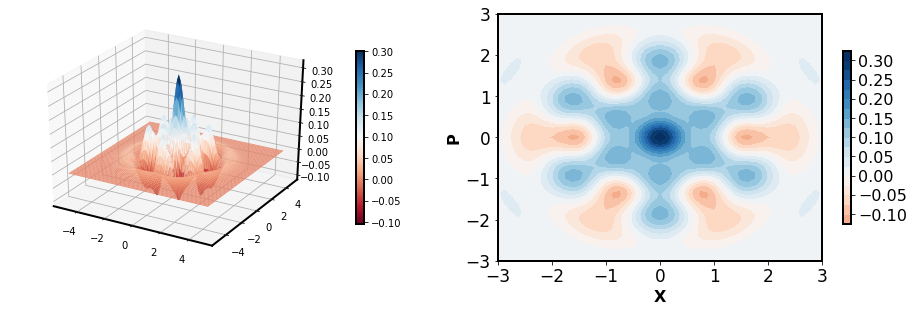

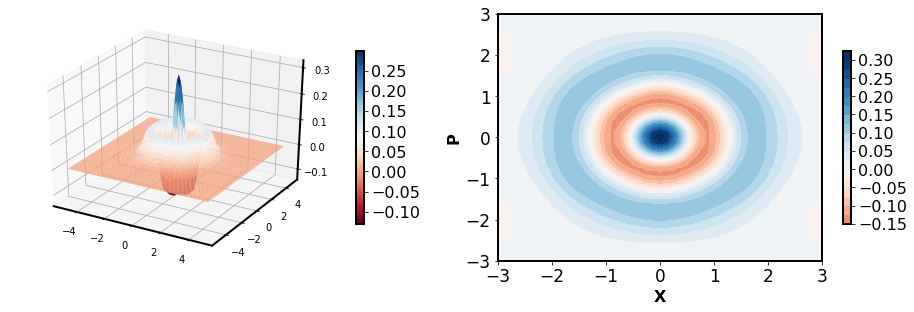

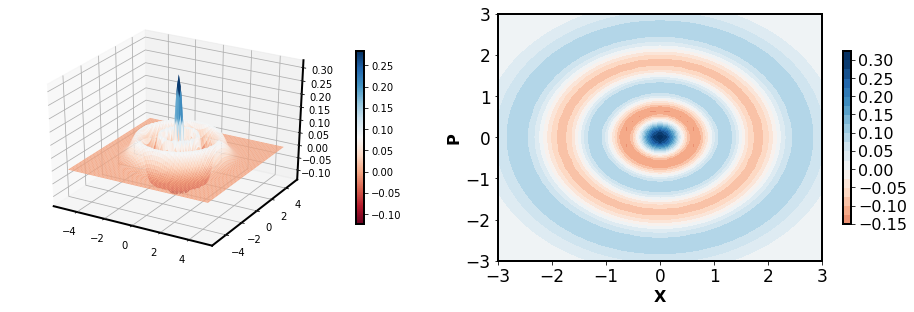

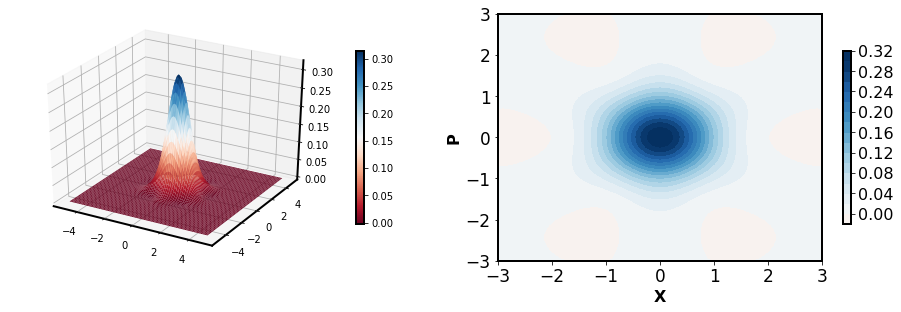

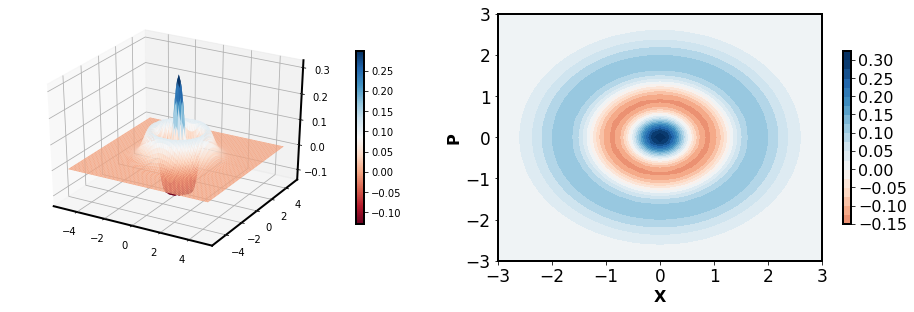

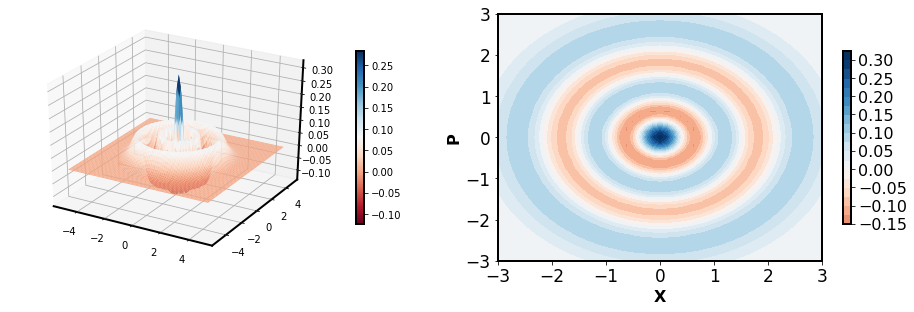

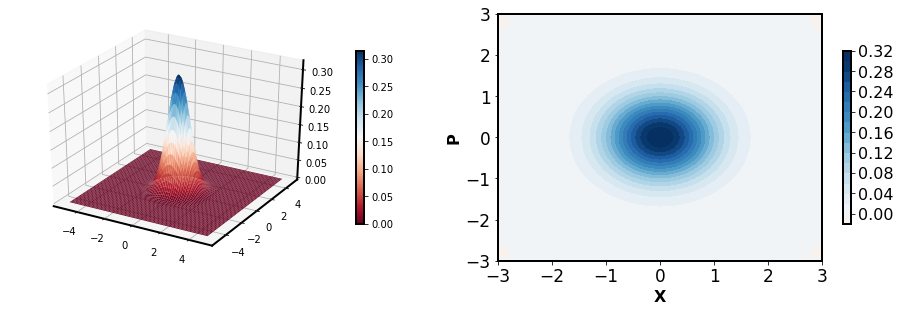

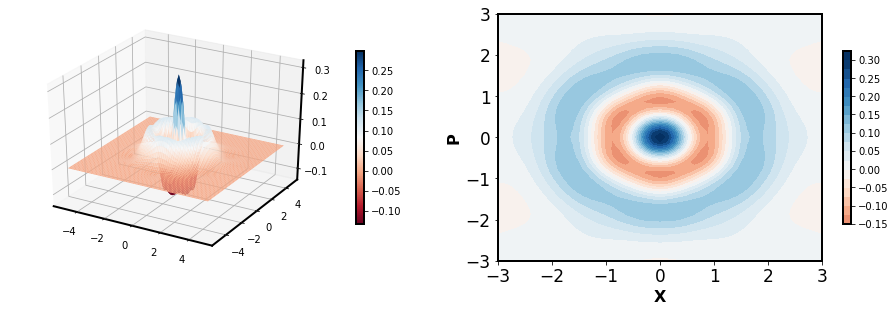

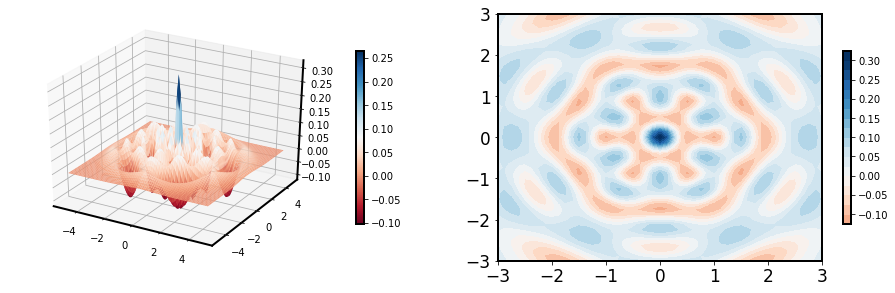

In [46]:
from pylab import *
rc('axes', linewidth=2)
fontsize=14
fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_0, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
cb.ax.tick_params(labelsize=16)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_0, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)


#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_1, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
cb.ax.tick_params(labelsize=16)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_1, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
cb.ax.tick_params(labelsize=16)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_2, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
cb.ax.tick_params(labelsize=16)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_2, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_3, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
cb.ax.tick_params(labelsize=16)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_3, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_4, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
cb.ax.tick_params(labelsize=16)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_4, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_5, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
cb.ax.tick_params(labelsize=16)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_5, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_6, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
cb.ax.tick_params(labelsize=16)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_6, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_7, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_7, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_8, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_8, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)



C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\transforms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


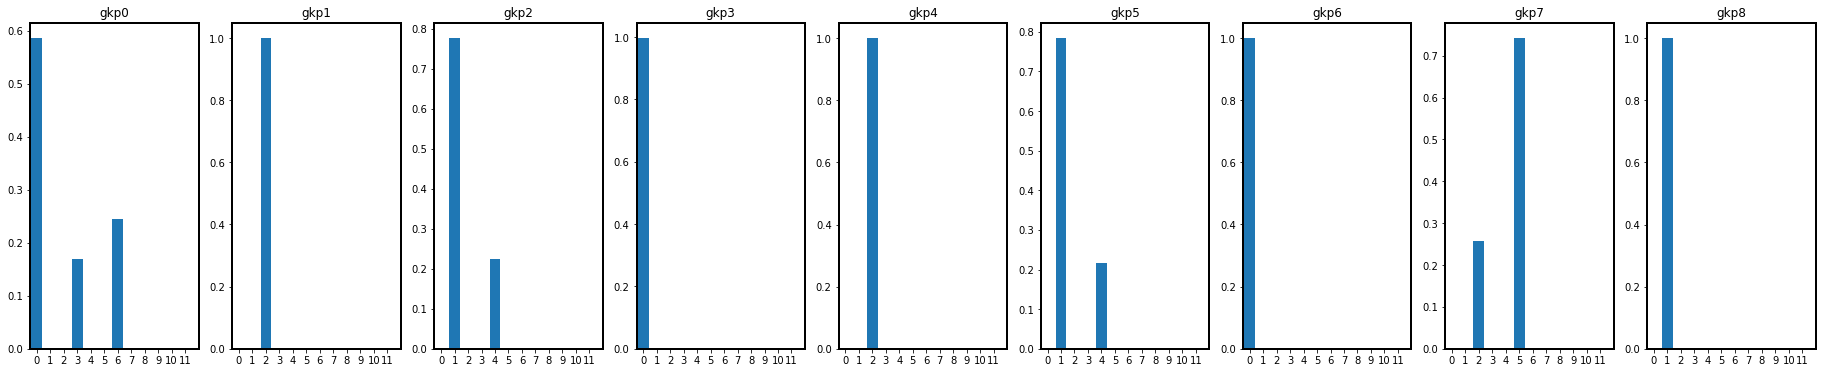

In [47]:
fig, axes = plt.subplots(1, 9, figsize=(32,6))
bar0 = axes[0].bar(range(N_dim), tri0.diag())
lbl0 = axes[0].set_title("gkp0")
lim0 = axes[0].set_xlim([-.5, 12])

bar1 = axes[1].bar(range(N_dim), tri1.diag())
lbl1 = axes[1].set_title("gkp1")
lim1 = axes[1].set_xlim([-.5, 12])

bar2 = axes[2].bar(range(N_dim), tri2.diag())
lbl2 = axes[2].set_title("gkp2")
lim2 = axes[2].set_xlim([-.5, 12])
bar3 = axes[3].bar(range(N_dim), tri3.diag())
lbl3 = axes[3].set_title("gkp3")
lim3 = axes[3].set_xlim([-.5, 12])

bar4 = axes[4].bar(range(N_dim), tri4.diag())
lbl4 = axes[4].set_title("gkp4")
lim4 = axes[4].set_xlim([-.5, 12])

bar5 = axes[5].bar(range(N_dim), tri5.diag())
lbl5 = axes[5].set_title("gkp5")
lim5 = axes[5].set_xlim([-.5, 12])

bar5 = axes[6].bar(range(N_dim), tri6.diag())
lbl5 = axes[6].set_title("gkp6")
lim5 = axes[6].set_xlim([-.5, 12])
bar5 = axes[7].bar(range(N_dim), tri7.diag())
lbl5 = axes[7].set_title("gkp7")
lim5 = axes[7].set_xlim([-.5, 12])
bar5 = axes[8].bar(range(N_dim), tri8.diag())
lbl5 = axes[8].set_title("gkp8")
lim5 = axes[8].set_xlim([-.5, 12])
axes[0].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[1].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[2].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[3].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[4].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[5].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[6].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[7].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[8].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])

plt.show()


Text(0.5,0.92,'mixture gkp ')

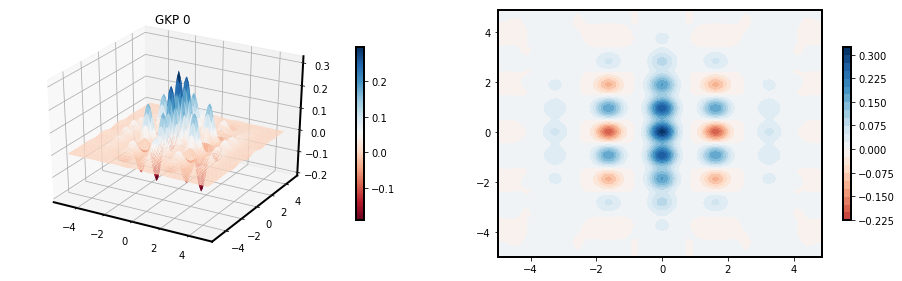

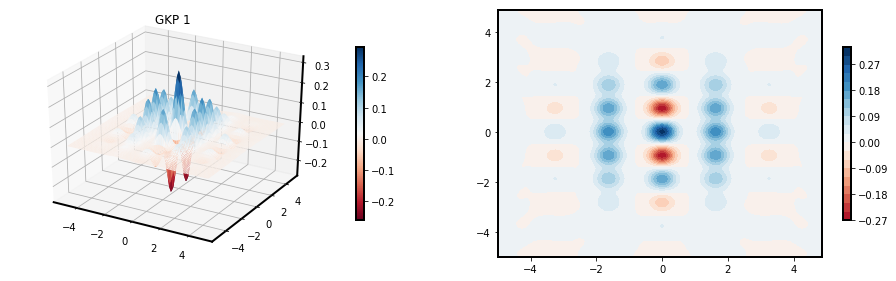

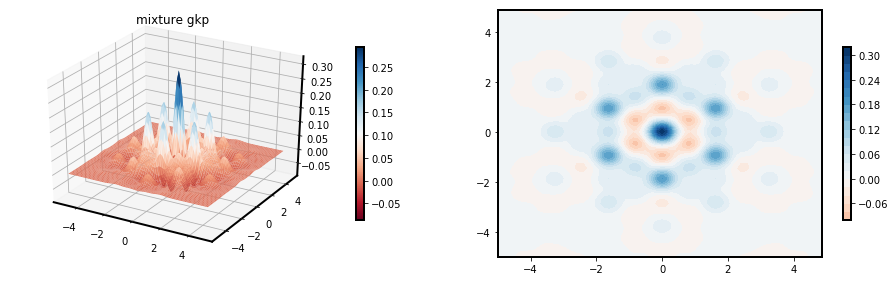

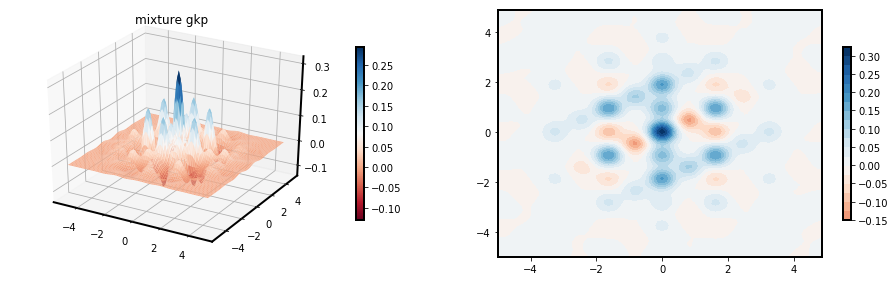

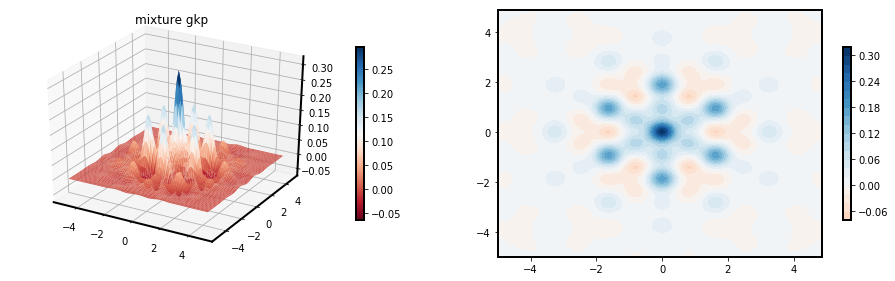

In [74]:
#Hex GKP states of dimension 2 and different mixed states from the GKP
code_d=2
hex_gkp0=my_hex_GKP(0,code_d,0.4,35)
hex_gkp1=my_hex_GKP(1,code_d,0.4,35)
hex_gkp_mix1=(hex_gkp1+Phase(np.pi/3)*hex_gkp1*Phase(np.pi/3).dag()+Phase(2*np.pi/3)*hex_gkp1*Phase(2*np.pi/3).dag())
hex_gkp_mix2=(hex_gkp0+Phase(np.pi/3)*hex_gkp1*Phase(np.pi/3).dag())
hex_gkp_mix3=(hex_gkp0+Phase(np.pi/3)*hex_gkp0*Phase(np.pi/3).dag()+Phase(2*np.pi/3)*hex_gkp0*Phase(2*np.pi/3).dag())


W_hex_mix1=wigner(hex_gkp_mix1/hex_gkp_mix1.tr(),xvec,xvec)
W_hex_mix2=wigner(hex_gkp_mix2/hex_gkp_mix2.tr(),xvec,xvec)
W_hex_mix3=wigner(hex_gkp_mix3/hex_gkp_mix3.tr(),xvec,xvec)
W_hex0=wigner(hex_gkp0,xvec,xvec)
W_hex1=wigner(hex_gkp1,xvec,xvec)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_hex0, 20, cmap=cm.RdBu, vmin=-1/np.pi, vmax=1/np.pi)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_hex0, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('GKP 0')

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_hex1, 20, cmap=cm.RdBu, vmin=-1/np.pi, vmax=1/np.pi)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_hex1, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('GKP 1')

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_hex_mix1, 20, cmap=cm.RdBu, vmin=-1/np.pi, vmax=1/np.pi)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_hex_mix1, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('mixture gkp')

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_hex_mix2, 20, cmap=cm.RdBu, vmin=-1/np.pi, vmax=1/np.pi)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_hex_mix2, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('mixture gkp ')

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_hex_mix3, 20, cmap=cm.RdBu, vmin=-1/np.pi, vmax=1/np.pi)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_hex_mix3, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('mixture gkp ')

The probability of a sucessful detection is: 0.3067749706335233
BS has reflectivity 0.5  and I am detecting the | <function num at 0x00000136D7060048> > state, where my detector has efficiency 1


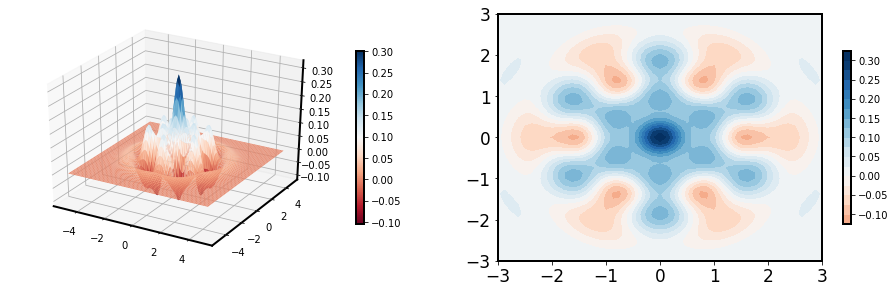

In [88]:

amp=1.255
sq=.24

state=sq_tri_cat(sq,amp);
W_start=wigner(state,xvec,xvec);

tri0_ph=catalysis(state,Phase(np.pi/3)*state*Phase(np.pi/3).dag(),1/2,0,eta,N_dim)
W_tri0_ph=wigner(tri0_ph,xvec,xvec);

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_tri0_ph, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_tri0_ph, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')

plt.show()

fidelity with gkp: 0.7851052729465


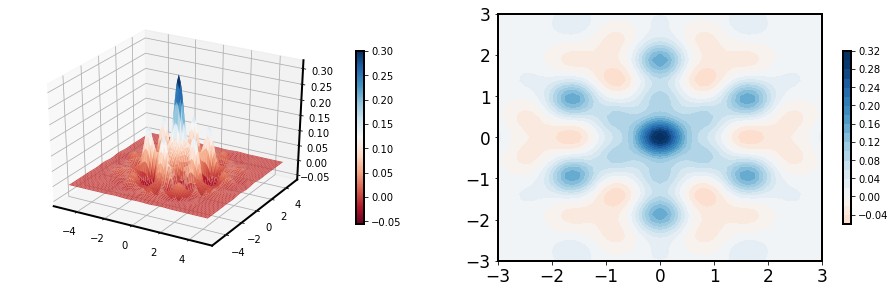

In [95]:
code_d=2
hex_gkp0=my_hex_GKP(0,code_d,0.44,35)

hex_comb=(hex_gkp0+Phase(np.pi/3)*hex_gkp0*Phase(np.pi/3).dag()+Phase(2*np.pi/3)*hex_gkp0*Phase(2*np.pi/3).dag())
test=hex_comb/hex_comb.tr()

w_test=wigner(test,xvec,xvec)
fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, w_test, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, w_test, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
fid=fidelity(tri0_ph,test)
print('fidelity with gkp:',fid**2)

In [86]:
fidelity(tri0_ph,test)

0.874555910029143